In [1]:
import os
import time
import h5py
import numpy as np
import pyfftw as ft
import matplotlib
import matplotlib.cm as cm
import matplotlib.mlab as mlab
import matplotlib.pyplot as plt
import pyJHTDB
from pyJHTDB.dbinfo import isotropic1024coarse
from pyJHTDB import libJHTDB

In [2]:
N = 1024

In [3]:
Q = np.zeros((N,N,N),dtype='float32')
R = np.zeros((N,N,N),dtype='float32')
S2 = np.zeros((N,N,N), dtype='float32')

In [4]:
start = time.time()

nproc = 8
nx = N//nproc

lQ = np.zeros((N//nproc,N,N), dtype='float32')
lR = np.zeros((N//nproc,N,N), dtype='float32')

folder = '/home/idies/workspace/scratch'

for k in range(nproc):
    filename = 'ref-Q-'+str(k)+'-(t=0.0).npz'
    files = folder+'/'+filename
    
    content = np.load(files)
    lQ = content['Q']
    
    Q[k*nx:(k+1)*nx,:,:] = lQ[:,:,:]
    
    filename = 'ref-R-'+str(k)+'-(t=0.0).npz'
    files = folder+'/'+filename
    
    content = np.load(files)
    lR = content['R']
    
    R[k*nx:(k+1)*nx,:,:] = lR[:,:,:]
    
end = time.time()
print(end-start)

155.76985383


In [5]:
start = time.time()

nproc = 8
nx = N//nproc

lS2 = np.zeros((N//nproc,N,N), dtype='float32')

folder = '/home/idies/workspace/scratch'

for k in range(nproc):
    filename = 'ref-strainrate-'+str(k)+'.npz'
    files = folder+'/'+filename
    
    content = np.load(files)
    lS2 = content['S2']
    
    S2[k*nx:(k+1)*nx,:,:] = lS2[:,:,:]
    
end = time.time()
print(end-start)

57.3081221581


In [6]:
del lQ,lR,lS2

In [7]:
avg = np.average(S2)
print(avg)

249.219


In [8]:
print(avg/2)

124.609298706


In [9]:
import pymp

In [10]:
def FindJointPDF(x,y,lowerLim_x,upperLim_x,lowerLim_y,upperLim_y,bins_x,bins_y):
    x=x.flatten()
    y=y.flatten()
    totL=len(x)
    xedges=np.linspace(lowerLim_x,upperLim_x,bins_x+1,endpoint=True); dx=xedges[1]-xedges[0]
    yedges=np.linspace(lowerLim_y,upperLim_y,bins_y+1,endpoint=True); dy=yedges[1]-yedges[0]
    jPDF,xedges,yedges=np.histogram2d(x,y,bins=(xedges,yedges))
    jPDF=jPDF/(dx*dy*totL)
    gridX,gridY=np.meshgrid(xedges[0:-1]+0.5*dx,yedges[0:-1]+0.5*dy)
    return jPDF.T,gridX,gridY

In [11]:
os.environ['TMPDIR']='/home/idies/workspace/scratch'

In [12]:
def FindJointPDFmp(x,y,lowerLim_x,upperLim_x,lowerLim_y,upperLim_y,bins_x,bins_y,threads=1):
    x=x.flatten()
    y=y.flatten()
    totL=len(x)
    xedges=np.linspace(lowerLim_x,upperLim_x,bins_x+1,endpoint=True); dx=xedges[1]-xedges[0]
    yedges=np.linspace(lowerLim_y,upperLim_y,bins_y+1,endpoint=True); dy=yedges[1]-yedges[0]
    size = (xedges.shape[0]-1)*(yedges.shape[0]-1)
    
    chk = x.shape[0]//threads
    shS = pymp.shared.array((threads,bins_x,bins_y), dtype='float32')
    with pymp.Parallel(threads) as p:
        for idx in p.range(0,threads):
            jPDF,xedges,yedges=np.histogram2d(x[idx*chk:(idx+1)*chk],y[idx*chk:(idx+1)*chk],bins=(xedges,yedges))
            shS[idx][:] = jPDF[:]
    
    jPDFg = np.zeros((bins_x,bins_y),dtype='float32')
    for idx in range(threads):
        jPDFg[:] += shS[idx][:]
    
    jPDF=jPDFg/(dx*dy*totL)
    gridX,gridY=np.meshgrid(xedges[0:-1]+0.5*dx,yedges[0:-1]+0.5*dy)
    return jPDF.T,gridX,gridY

In [13]:
t1=time.time()
q=Q.flatten()
r=R.flatten()
q=q/avg
r=r/(avg**1.5)
t2=time.time()
print('Done!! Cost= %0.2f seconds\n' %(t2-t1))

Done!! Cost= 186.06 seconds



In [14]:
t1=time.time()
Ngrid=960;rmin=-60.0;rmax=60.0;qmin=-60.0;qmax=60.0 # Constants for jPDF
jPDF,gridX,gridY=FindJointPDFmp(r,q,rmin,rmax,qmin,qmax,Ngrid,Ngrid,threads=8)
t2=time.time()
print('Done!! Cost= %0.2f seconds\n' %(t2-t1))

Done!! Cost= 1664.92 seconds



/home/idies/anaconda3/envs/py27/lib/python2.7/site-packages/ipykernel/__main__.py:29: RuntimeWarning: divide by zero encountered in log


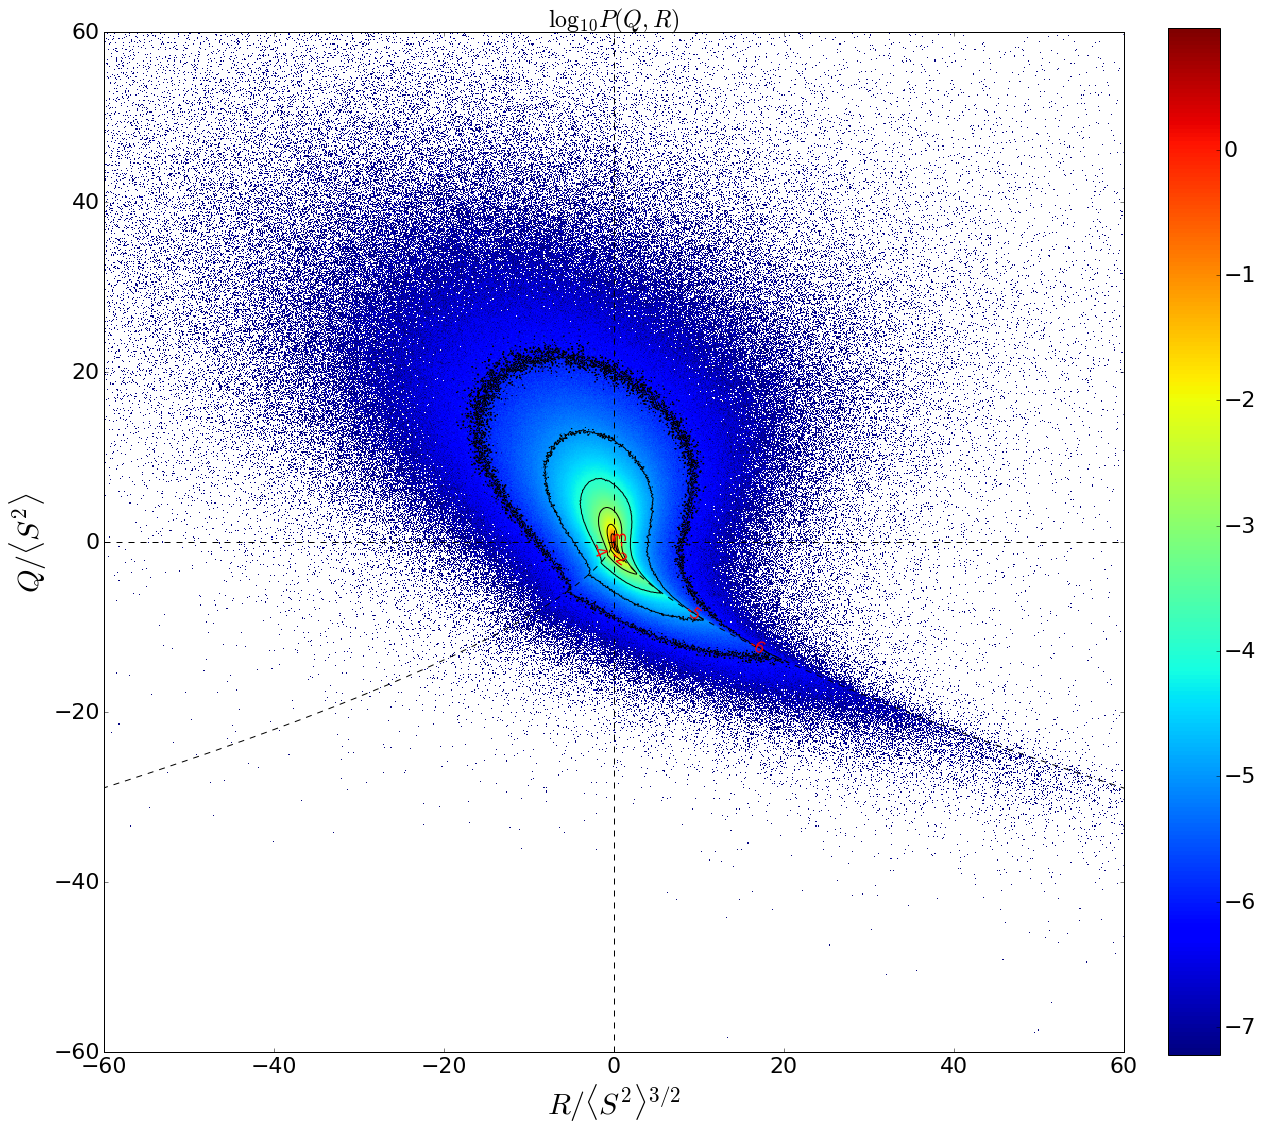

In [22]:
%matplotlib inline

fmt={}
fig = plt.figure(figsize=(20,20))

matplotlib.rc('xtick', labelsize=35) 
matplotlib.rc('ytick', labelsize=35) 

###################################################

Qc=np.linspace(qmin,0,50)
Rc1=-(2./27.)*((-3.*Qc)**1.5)
Rc2=(2./27.)*((-3.*Qc)**1.5)
plt.plot(Rc1,Qc,'--k')
plt.plot(Rc2,Qc,'--k')
plt.plot([0,0],[qmin,qmax],'--k')
plt.plot([rmin,rmax],[0,0],'--k')
plt.axis([rmin,rmax,qmin,qmax])
plt.xlabel(r'$R/\langle S^2\rangle^{3/2}$',fontsize=35)
plt.ylabel(r'$Q/\langle S^2\rangle$',fontsize=35)
plt.title(r'$\log_{10} P({Q,R})$',fontsize=35)

###################################################

logjPDF = np.log(jPDF)/np.log(10)

cax = plt.imshow(logjPDF,interpolation='none',extent=(rmin,rmax,qmin,qmax),origin='lower', aspect='equal')
cbar = fig.colorbar(cax,fraction=0.046, pad=0.04)

N = 6
levels=np.logspace(-N,-1,num=N,base=10.0)#np.logspace[1e-5,1e-4,1e-3,1e-2,1e-1]
CS=plt.contour(gridX,gridY,jPDF,levels,colors='k')#[1::2] #extent=(-15,15,-15,15)
strs=['-6','-5','-4','-3','-2','-1']
for l,s in zip(CS.levels,strs):
    fmt[l]=s
plt.clabel(CS,levels,inline=False,fmt=fmt,fontsize=16,colors='r')

#plt.show()
plt.savefig('QR-jpdf-log.pdf', format='pdf', bbox_inches='tight')

/home/idies/anaconda3/envs/py27/lib/python2.7/site-packages/ipykernel/__main__.py:9: RuntimeWarning: divide by zero encountered in log


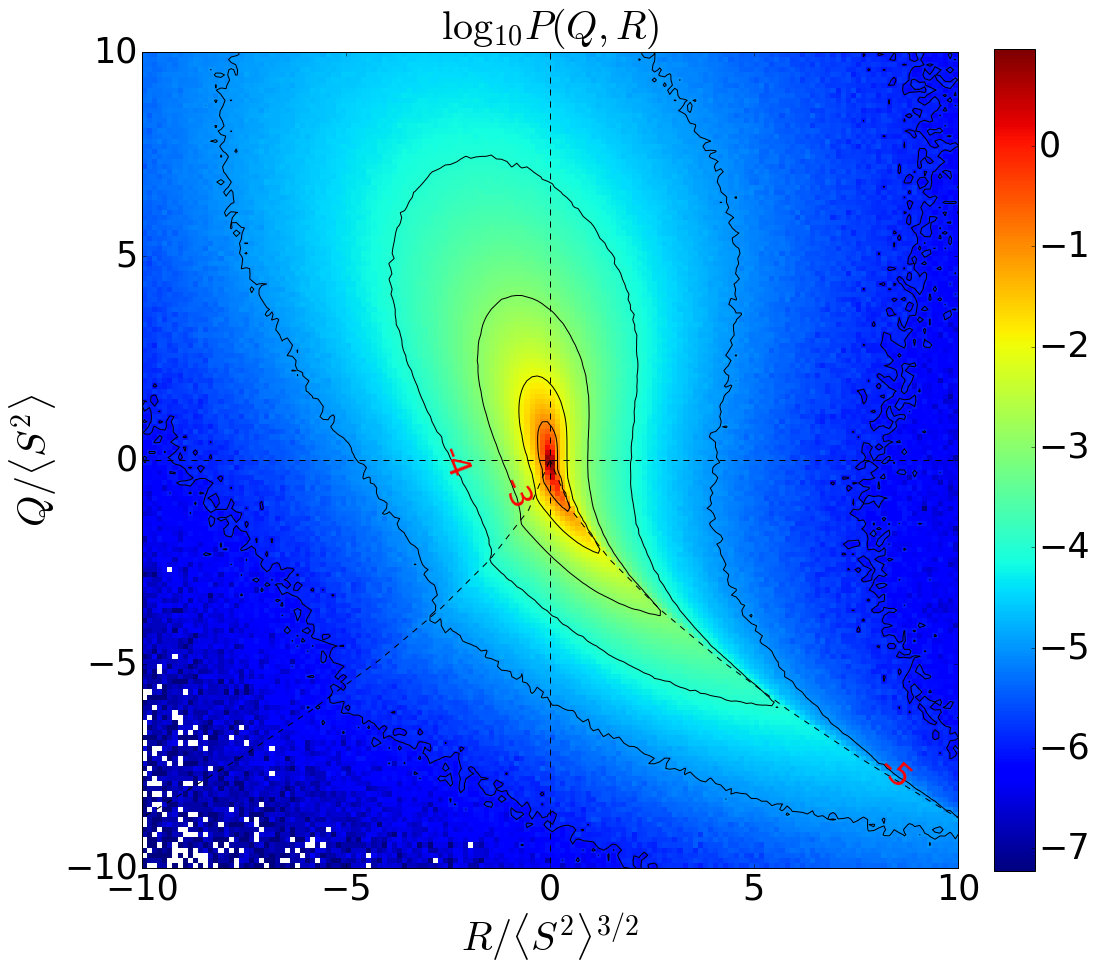

In [18]:
%matplotlib inline

fmt={}
fig = plt.figure(figsize=(16,16))

matplotlib.rc('xtick', labelsize=35) 
matplotlib.rc('ytick', labelsize=35) 

logjPDF = np.log(jPDF)/np.log(10)

cax = plt.imshow(logjPDF,interpolation='none',extent=(rmin,rmax,qmin,qmax),origin='lower', aspect='equal')
cbar = fig.colorbar(cax,fraction=0.046, pad=0.04)

levels=np.logspace(-6.,-1,num=6,base=10.0)#np.logspace[1e-5,1e-4,1e-3,1e-2,1e-1]
CS=plt.contour(gridX,gridY,jPDF,levels,colors='k')#[1::2] #extent=(-15,15,-15,15)
strs=['-6','-5','-4','-3','-2','-1']
for l,s in zip(CS.levels,strs):
    fmt[l]=s
plt.clabel(CS,levels,inline=False,fmt=fmt,fontsize=32,colors='r')

Qc=np.linspace(qmin,0,50)
Rc1=-(2./27.)*((-3.*Qc)**1.5)
Rc2=(2./27.)*((-3.*Qc)**1.5)
plt.plot(Rc1,Qc,'--k')
plt.plot(Rc2,Qc,'--k')
plt.plot([0,0],[qmin,qmax],'--k')
plt.plot([rmin,rmax],[0,0],'--k')
plt.axis([-10,10,-10,10])
plt.xlabel(r'$R/\langle S^2\rangle^{3/2}$',fontsize=40)
plt.ylabel(r'$Q/\langle S^2\rangle$',fontsize=40)
plt.title(r'$\log_{10} P({Q,R})$',fontsize=40,y=1.01)
plt.savefig('QR-jpdf-zoom.pdf', format='pdf', bbox_inches='tight')

/home/idies/anaconda3/envs/py27/lib/python2.7/site-packages/ipykernel/__main__.py:13: RuntimeWarning: divide by zero encountered in log


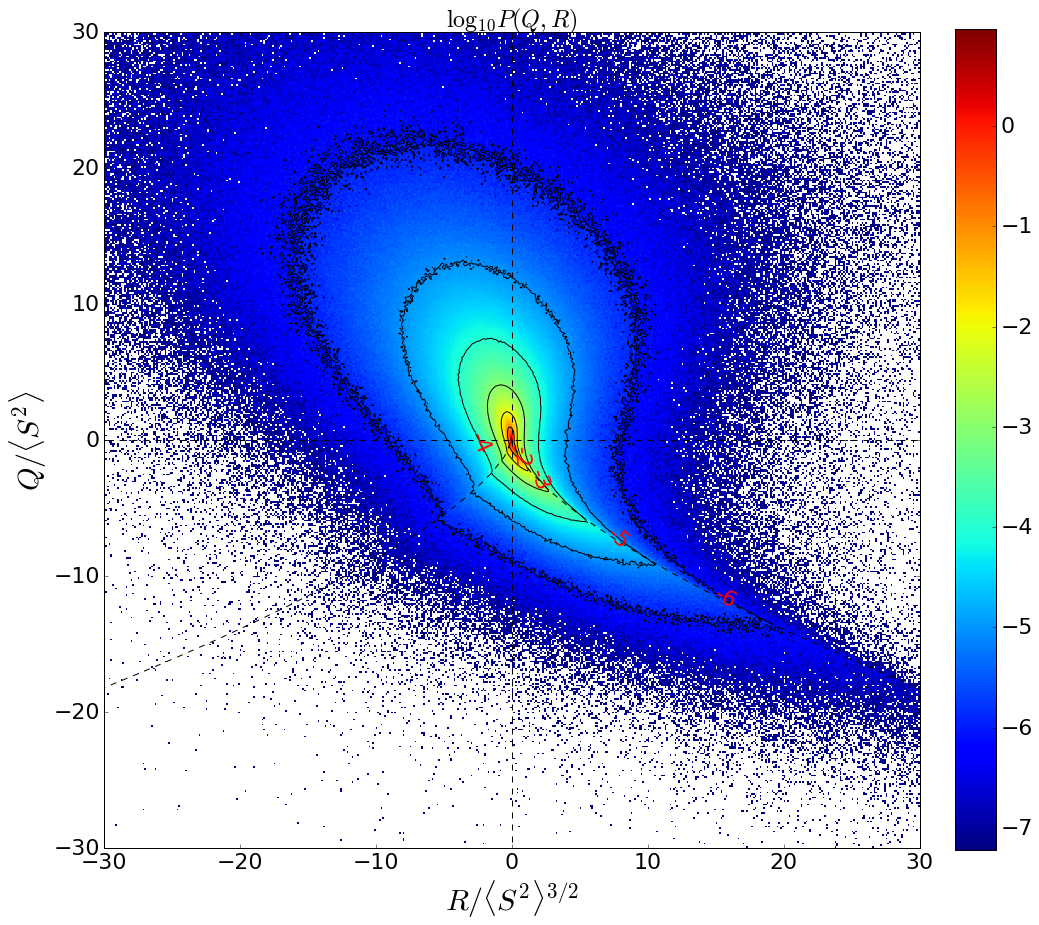

In [25]:
%matplotlib inline

fmt={}
fig = plt.figure(figsize=(16,16))
SIZE=20
plt.rc('font', size=SIZE)  # controls default text sizes
plt.rc('axes', titlesize=SIZE+4)  # fontsize of the axes title
plt.rc('axes', labelsize=SIZE+8)  # fontsize of the x any y labels
plt.rc('xtick', labelsize=SIZE+2)  # fontsize of the tick labels
plt.rc('ytick', labelsize=SIZE+2)  # fontsize of the tick labels
plt.rc('legend', fontsize=SIZE)  # legend fontsize

logjPDF = np.log(jPDF)/np.log(10)

cax = plt.imshow(logjPDF,interpolation='none',extent=(rmin,rmax,qmin,qmax),origin='lower', aspect='equal')
cbar = fig.colorbar(cax,fraction=0.046, pad=0.04)

levels=np.logspace(-6.,-1,num=6,base=10.0)#np.logspace[1e-5,1e-4,1e-3,1e-2,1e-1]
CS=plt.contour(gridX,gridY,jPDF,levels,colors='k')#[1::2] #extent=(-15,15,-15,15)
strs=['-6','-5','-4','-3','-2','-1']
for l,s in zip(CS.levels,strs):
    fmt[l]=s
plt.clabel(CS,levels,inline=False,fmt=fmt,fontsize=22,colors='r')

Qc=np.linspace(qmin,0,50)
Rc1=-(2./27.)*((-3.*Qc)**1.5)
Rc2=(2./27.)*((-3.*Qc)**1.5)
plt.plot(Rc1,Qc,'--k')
plt.plot(Rc2,Qc,'--k')
plt.plot([0,0],[qmin,qmax],'--k')
plt.plot([rmin,rmax],[0,0],'--k')
plt.axis([-30,30,-30,30])
plt.xlabel(r'$R/\langle S^2\rangle^{3/2}$',fontsize=30)
plt.ylabel(r'$Q/\langle S^2\rangle$',fontsize=30)
plt.title(r'$\log_{10} P({Q,R})$')
plt.savefig('QR-jpdf-zoom2.pdf', format='pdf', bbox_inches='tight')

/home/idies/anaconda3/envs/py27/lib/python2.7/site-packages/ipykernel/__main__.py:13: RuntimeWarning: divide by zero encountered in log


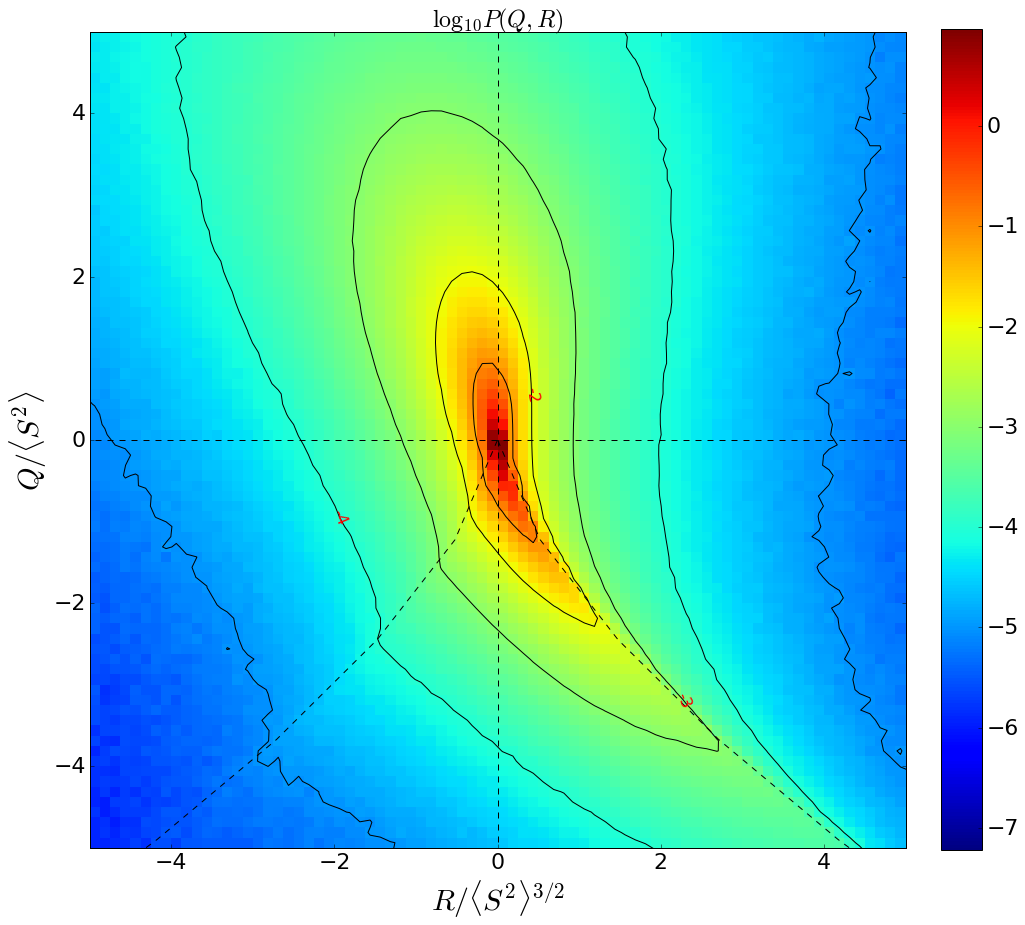

In [26]:
%matplotlib inline

fmt={}
fig = plt.figure(figsize=(16,16))
SIZE=20
plt.rc('font', size=SIZE)  # controls default text sizes
plt.rc('axes', titlesize=SIZE+4)  # fontsize of the axes title
plt.rc('axes', labelsize=SIZE+8)  # fontsize of the x any y labels
plt.rc('xtick', labelsize=SIZE+2)  # fontsize of the tick labels
plt.rc('ytick', labelsize=SIZE+2)  # fontsize of the tick labels
plt.rc('legend', fontsize=SIZE)  # legend fontsize

logjPDF = np.log(jPDF)/np.log(10)

cax = plt.imshow(logjPDF,interpolation='none',extent=(rmin,rmax,qmin,qmax),origin='lower', aspect='equal')
cbar = fig.colorbar(cax,fraction=0.046, pad=0.04)

levels=np.logspace(-6.,-1,num=6,base=10.0)#np.logspace[1e-5,1e-4,1e-3,1e-2,1e-1]
CS=plt.contour(gridX,gridY,jPDF,levels,colors='k')#[1::2] #extent=(-15,15,-15,15)
strs=['-6','-5','-4','-3','-2','-1']
for l,s in zip(CS.levels,strs):
    fmt[l]=s
plt.clabel(CS,levels,inline=False,fmt=fmt,fontsize=16,colors='r')

Qc=np.linspace(qmin,0,50)
Rc1=-(2./27.)*((-3.*Qc)**1.5)
Rc2=(2./27.)*((-3.*Qc)**1.5)
plt.plot(Rc1,Qc,'--k')
plt.plot(Rc2,Qc,'--k')
plt.plot([0,0],[qmin,qmax],'--k')
plt.plot([rmin,rmax],[0,0],'--k')
plt.axis([-5,5,-5,5])
plt.xlabel(r'$R/\langle S^2\rangle^{3/2}$',fontsize=30)
plt.ylabel(r'$Q/\langle S^2\rangle$',fontsize=30)
plt.title(r'$\log_{10} P({Q,R})$')
plt.savefig('QR-jpdf-zoom3.pdf', format='pdf', bbox_inches='tight')

In [19]:
t1=time.time()

Nbins = 120
qtemp = q[:] 
lbins = np.linspace(qmin,qmax,Nbins,endpoint=True)
histredQ,edgesredQ = np.histogram(qtemp,lbins,normed=True)

t2=time.time()
print('Done!! Cost= %0.2f seconds\n' %(t2-t1))

Done!! Cost= 146.22 seconds



In [20]:
t1=time.time()

Nbins = 120
rtemp = r[:] 
lbins = np.linspace(rmin,rmax,Nbins,endpoint=True)
histredR,edgesredR = np.histogram(rtemp,lbins,normed=True)

t2=time.time()
print('Done!! Cost= %0.2f seconds\n' %(t2-t1))

Done!! Cost= 149.45 seconds



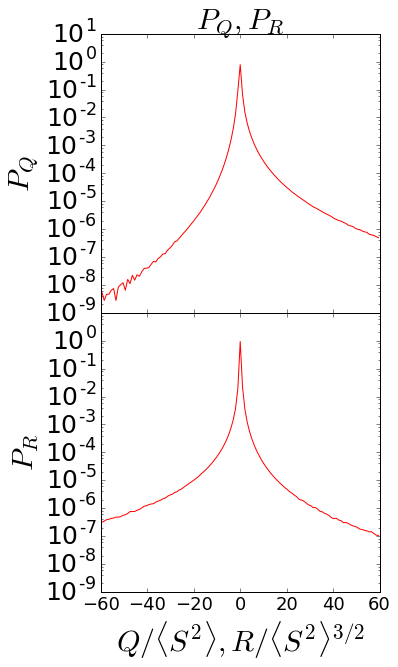

In [28]:
%matplotlib inline 
    
fig = plt.figure(figsize=(5,10))

######################################

ax1 = plt.subplot(211)
ax2 = plt.subplot(212,sharex=ax1)

matplotlib.rc('xtick', labelsize=18) 
matplotlib.rc('ytick', labelsize=25) 

plt.subplots_adjust(hspace=.0)

######################################
    
SIZE = 12
plt.rcParams['figure.figsize'] = (5, 10)
ax1.set_ylabel(r'$P_{Q}$',size=30)
ax2.set_xlabel(r'$ Q/{\langle S^2\rangle},R/{\langle S^2\rangle^{{3/2}}}$',size=30)
ax2.set_ylabel(r'$P_{R}$',size=30)
plt.setp(ax1.get_xticklabels(), visible=False)

######################################

leftQ = edgesredQ[0:(Nbins-1)]
rightQ = edgesredQ[1:Nbins]

ax1.set_xlim((-60,60))
ax1.set_ylim((10**(-9),10**(1)))
ax1.semilogy((leftQ+rightQ)/2.,histredQ,'r',label='Unfiltered')

yticks = [10**(-9),10**(-8),10**(-7),10**(-6),10**(-5),10**(-4),10**(-3),10**(-2),10**(-1),10**(0),10**(1)]
ax1.set_yticks(yticks)

######################################

leftR = edgesredR[0:(Nbins-1)]
rightR = edgesredR[1:Nbins]

ax2.set_xlim((-60,60))
ax2.set_ylim((10**(-9),10**(1)))
ax2.semilogy((leftR+rightR)/2.,histredR,'r',label='Unfiltered')

yticks = [10**(-9),10**(-8),10**(-7),10**(-6),10**(-5),10**(-4),10**(-3),10**(-2),10**(-1),10**(0)]
ax2.set_yticks(yticks)

######################################

ax1.title.set_text(r'$P_{Q},P_{R}$')
ax1.title.set_size(30)

plt.subplots_adjust(wspace = 0.1)
plt.savefig('QR-pdfs.pdf', format='pdf', bbox_inches='tight', transparent=True)